# 1. 검증용 데이터셋 준비

## 영어 표지판 이미지 5장

In [3]:
import os
 
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/sign/'
file_list = os.listdir(img_dir)
file_list

['5.jpeg', '3.jpeg', '4.jpeg', '1.jpeg', '2.jpeg']

# 2. OCR 테스트

## 1) keras-ocr

In [4]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list]

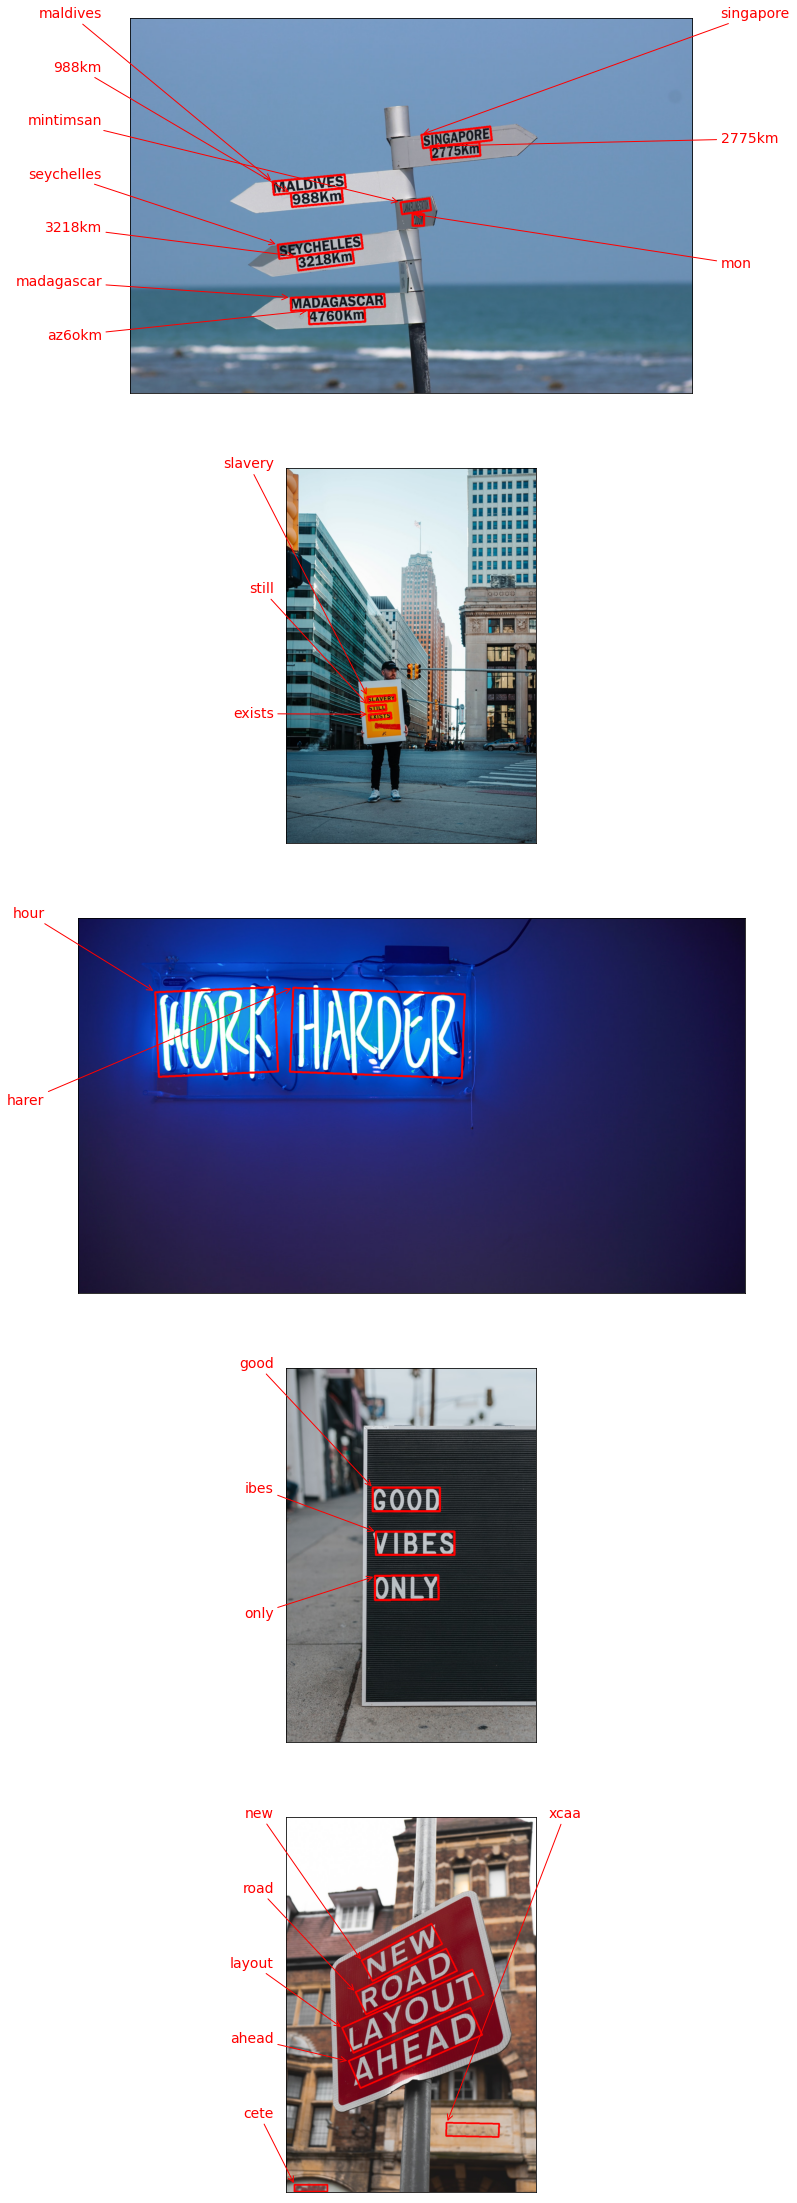

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 2) Tesseract

In [7]:
import pytesseract
from PIL import Image
from pytesseract import Output

def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [8]:
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_cropped'

for file in file_list:
    print(f'[{file}]')
    try:
        recognize_images(os.path.join(img_dir, file), save_dir)
    except:
        print(f'Cannot recognize characters from {file}')

[5.jpeg]
CSSA

SINGA

MALDIVES

ee

98s8KkKm

\

MADAGASCAR

\

7

A760Km

rt

en

ame


=


Done
[3.jpeg]

Ag



yo

ag

a8 Ba

a

Ja

EG:

Bo

ll


Done
[4.jpeg]

Done
[1.jpeg]
;

Done
[2.jpeg]
A

Done


# 3. 모델 비교 분석하기

In [9]:
def compare_ocr(file):
    print('[keras-ocr]')
    idx = file_list.index(file)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('\n[Tesseract]')
    recognize_images(os.path.join(img_dir, file), save_dir)

## 1) 정면을 보고 있는 표지판

[keras-ocr]


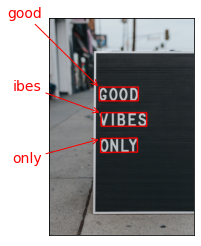


[Tesseract]
;

Done


In [11]:
compare_ocr('1.jpeg')

- keras-ocr: vibes를 ibes로 읽어 'v'를 인지하지는 못했지만, 그래도 잘 나온 것을 확인할 수 있다.
- tesseract: 읽어내지를 못했다.

## 2) 기울기가 있는 표지판

[keras-ocr]


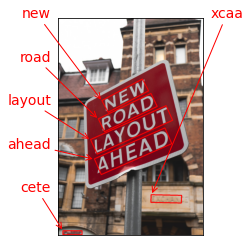


[Tesseract]
A

Done


In [12]:
compare_ocr('2.jpeg')

- keras-ocr: 기울어져 있어도 정확하게 읽어낸 것은 물론, 뒤에 잘 보이지 않는 작은 글자까지 읽어냈다.
- tesseract: A 하나만 출려됐다. 제대로 읽어내지 못한 것을 알 수 있다.

## 3) 작은 글자가 있는 표지판

[keras-ocr]


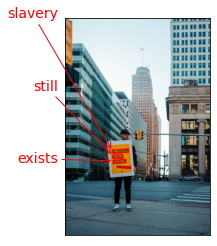


[Tesseract]

Ag



yo

ag

a8 Ba

a

Ja

EG:

Bo

ll


Done


In [13]:
compare_ocr('3.jpeg')

- keras-ocr: 정확하게 읽어냈다.
- tesseract: 알 수 없는 단어들이 나왔다.

## 4) 흘려쓴 것 같은 표지판

[keras-ocr]


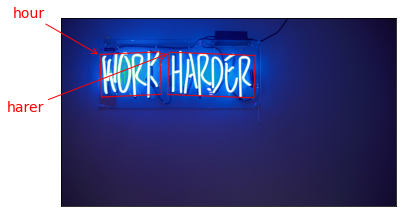


[Tesseract]

Done


In [14]:
compare_ocr('4.jpeg')

- keras-ocr: 글씨가 출력되긴 했지만, 정확한 글씨가 나오지는 않았다.
- tesseract: 아무것도 출력되지 않았다.

## 5) 여러 글씨가 있는 표지판

[keras-ocr]


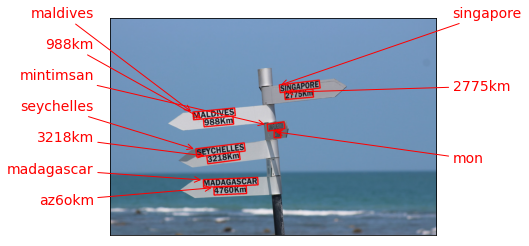


[Tesseract]
CSSA

SINGA

MALDIVES

ee

98s8KkKm

\

MADAGASCAR

\

7

A760Km

rt

en

ame


=


Done


In [15]:
compare_ocr('5.jpeg')

- keras-ocr: 대부분 정확한 글씨가 나왔다. 4760km가 az60km으로 잘못나오긴 했다.
- tesseract: maldives는 제대로 출력됐지만 알 수 없는 단어들이 더 많이 나왔다.

# 5. 결과

- 표지판을 읽어주는 OCR의 경우 시각장애인 등 시각에 불편을 겪는 사람들이 길을 찾는 상황에서 유용하게 사용할 수 있을 것이다. 
- keras-ocr은 대분 잘 읽어주는 것을 확인하였지만 tesseract는 성능이 매우 떨어졌다.
- 따라서 keras-ocr을 사용하는 것이 더 타당할 것이다.

# 6. 회고

생각보다 짧은 코드로 쉽게 구현되는 점이 신기하였다. tesseract는 성능이 너무 안 좋아 keras와 비교하기 민망할 정도였는데 구글 ocr도 써보고 비교를 해보고 싶다. 개인사정으로 구글 ocr은 사용하지 못했지만 다음에 기회가 된다면 꼭 써보고 싶다.